In [1]:
from fastai.vision import *

## Data Collection 

In [3]:
# URLs.CIFAR_100

# path = untar_data(URLs.CIFAR_100); path
path = Path('/datasets/fastai/imagenette2-160')

In [4]:
fnames = get_image_files(path, recurse=True); fnames[:5]

[PosixPath('/storage/meme_classifier/test/00000671.jpg'),
 PosixPath('/storage/meme_classifier/test/n03888257_32608.JPEG'),
 PosixPath('/storage/meme_classifier/test/00000313.jpg'),
 PosixPath('/storage/meme_classifier/test/n02102040_2306.JPEG'),
 PosixPath('/storage/meme_classifier/test/n03445777_1386.JPEG')]

In [8]:
not_meme = random.choices(fnames, k=1000); not_meme[:5]

[PosixPath('/storage/meme_classifier/train/not_meme/n02102040_2495.JPEG'),
 PosixPath('/storage/meme_classifier/train/meme/00000207.jpg'),
 PosixPath('/storage/meme_classifier/train/meme/00000131.jpg'),
 PosixPath('/storage/meme_classifier/test/n03028079_14885.JPEG'),
 PosixPath('/storage/meme_classifier/train/meme/00000534.jpg')]

In [12]:
classes = ['meme', 'not_meme']

In [10]:
folder = Path('/storage/meme_classifier/train')
dest = folder/classes[1]
dest.mkdir(parents=True, exist_ok=True)
file = 'not_meme.csv'

In [97]:
for file in not_meme: shutil.copy(file, dest)

In [ ]:
dest = folder/classes[0]
dest.mkdir(parents=True, exist_ok=True)
file = 'memes.csv'
download_images(folder/file, dest, max_pics=1000)

In [98]:
for c in classes:
    print(c)
    verify_images(folder/c, delete=True, max_size=500)

meme


not_meme


## Create test set

In [11]:
path = Path('/storage/meme_classifier')
dest = path/'test'
dest.mkdir(parents=True, exist_ok=True)
not_meme_test = random.sample(get_image_files(folder/'not_meme'), k=472); not_meme_test[:5]

[PosixPath('/storage/meme_classifier/train/not_meme/n01440764_10066.JPEG'),
 PosixPath('/storage/meme_classifier/train/not_meme/ILSVRC2012_val_00037369.JPEG'),
 PosixPath('/storage/meme_classifier/train/not_meme/n03394916_28651.JPEG'),
 PosixPath('/storage/meme_classifier/train/not_meme/n02102040_1695.JPEG'),
 PosixPath('/storage/meme_classifier/train/not_meme/n03425413_14249.JPEG')]

In [7]:
meme_test = random.sample(get_image_files(folder/'meme'), k=123); meme_test[:5]

[PosixPath('/storage/meme_classifier/train/meme/00000553.jpg'),
 PosixPath('/storage/meme_classifier/train/meme/00000317.jpg'),
 PosixPath('/storage/meme_classifier/train/meme/00000576.jpg'),
 PosixPath('/storage/meme_classifier/train/meme/00000166.jpg'),
 PosixPath('/storage/meme_classifier/train/meme/00000444.jpg')]

In [161]:
for file in not_meme_test: shutil.move(str(file), dest)

for file in meme_test: shutil.move(str(file), dest)

## Load Data

In [25]:
np.random.seed(42)
path = Path('/storage/meme_classifier')
tfms = get_transforms()
data = (ImageList.from_folder(path=path, include='train')
        .split_by_rand_pct()
        .label_from_folder()
        .add_test_folder(test_folder='test')
        .transform(tfms=tfms, size=224)
        .databunch(num_workers=4, bs=64)
        .normalize(imagenet_stats)
       )

In [26]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(['meme', 'not_meme'], 2, 1122, 280, 995)

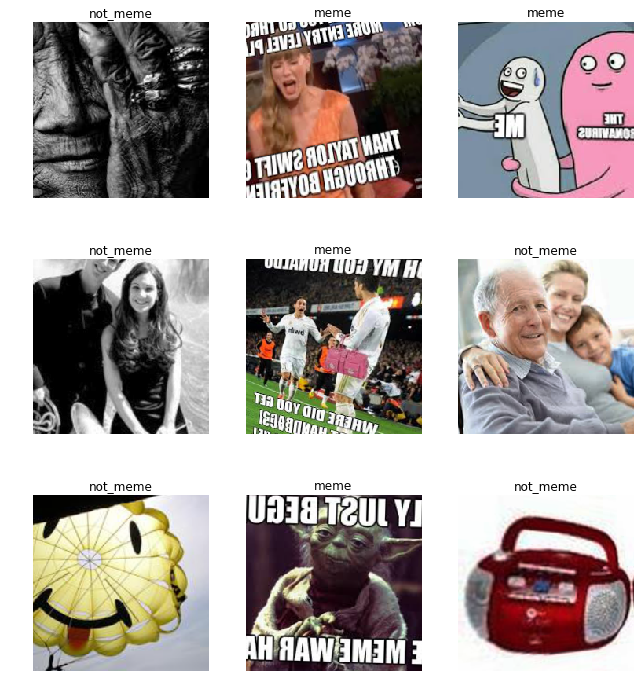

In [29]:
data.show_batch(rows=3, figsize=(9,10))

## Training Model

In [30]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [31]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.494434,0.261170,0.064286,00:11
1,0.301807,0.145971,0.039286,00:09


In [32]:
learn.save('stage-1')

## Interpretation : Resnet34 with freezed layers

In [11]:
learn.load('stage-1');

In [33]:
learn.validate(learn.data.valid_dl)

[0.14597146, tensor(0.0393)]

In [34]:
learn.validate(learn.data.train_dl)

[0.09498453, tensor(0.0303)]

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

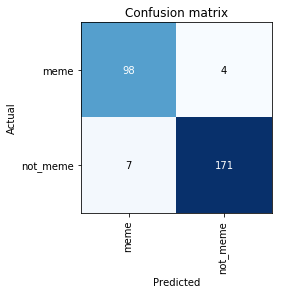

In [36]:
interp.plot_confusion_matrix()

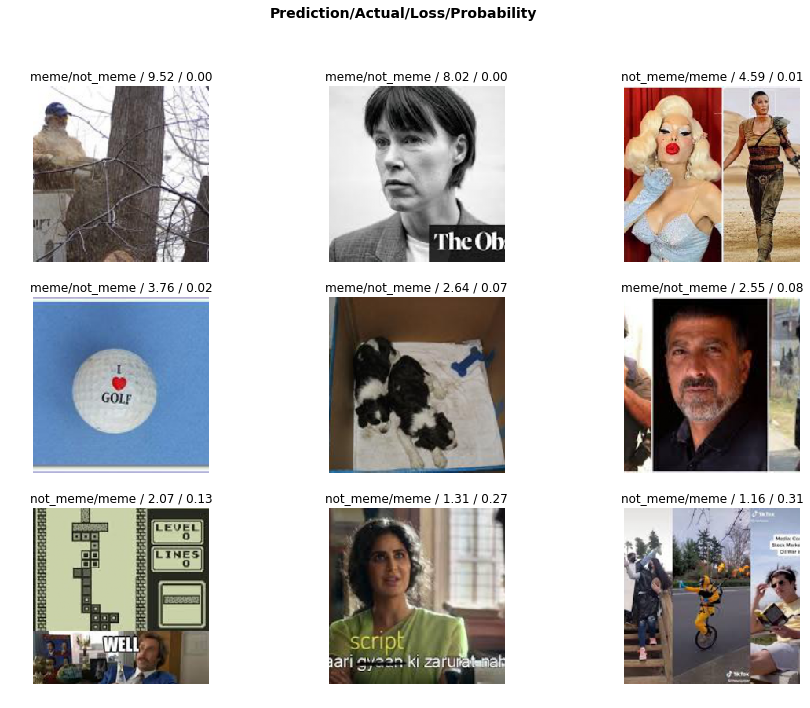

In [37]:
interp.plot_top_losses(9, figsize=(15,11))

## Unfreeze Model

In [38]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.load('stage-1');

In [39]:
learn.unfreeze()

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


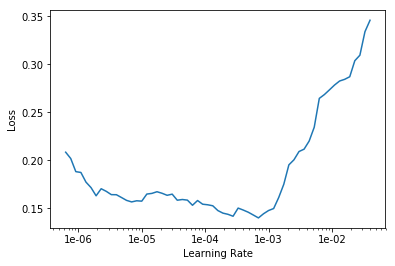

In [41]:
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.161266,0.093661,0.028571,00:12
1,0.136181,0.071503,0.021429,00:12


In [43]:
learn.save('stage-2')

## Interpretation : Resnet34 with unfreezed layers


In [29]:
learn.load('stage-2');

In [44]:
interp = ClassificationInterpretation.from_learner(learn)

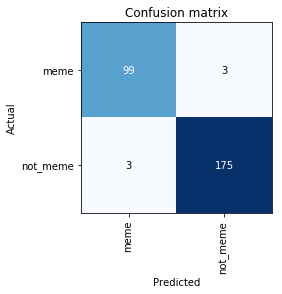

In [46]:
interp.plot_confusion_matrix()

## Data Cleanup

In [47]:
from fastai.widgets import *

In [48]:
# db = (ImageList.from_folder(path)
#                    .filter_by_folder(include='train')
#                    .split_none()
#                    .label_from_folder()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

In [54]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removed duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [55]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [56]:
learn_cln.load('stage-2');

In [51]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [52]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [58]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [59]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Training on cleaned dataset

In [60]:
data_cleaned = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv', valid_pct=0.2, ds_tfms=tfms, bs=64, size=224
                                        ).normalize(imagenet_stats)
data_cleaned.classes, len(data_cleaned.train_ds), len(data_cleaned.valid_ds) 

(['meme', 'not_meme'], 1101, 275)

In [94]:
learn = cnn_learner(data_cleaned, models.resnet34, metrics=error_rate)

learn.unfreeze()

In [95]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


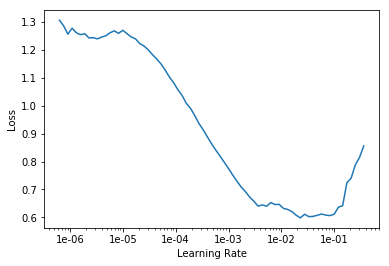

In [96]:
learn.recorder.plot()

In [97]:
learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.594055,0.248281,0.054545,00:13
1,0.304423,0.103202,0.021818,00:13
2,0.184755,0.068105,0.010909,00:13
3,0.127976,0.063344,0.010909,00:13


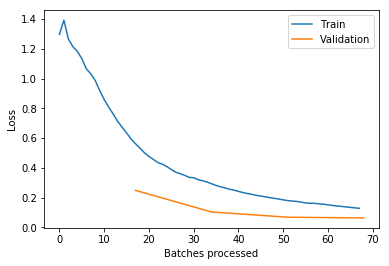

In [98]:
learn.recorder.plot_losses()

In [99]:
learn.save('stage-cleaned-resnet34')

## Using Resnet50

In [101]:
learn = cnn_learner(data_cleaned, models.resnet50, metrics=error_rate)
learn.unfreeze()

In [102]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


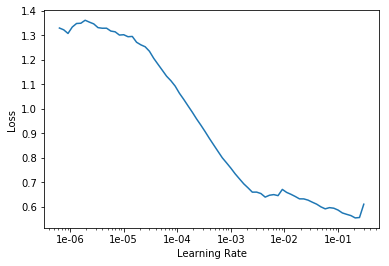

In [103]:
learn.recorder.plot()

In [104]:
learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.545493,0.323206,0.080000,00:25
1,0.310237,0.218734,0.032727,00:23
2,0.200599,0.138837,0.018182,00:23
3,0.139079,0.114750,0.014545,00:23


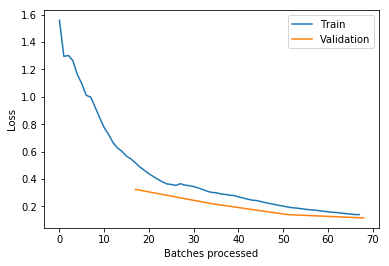

In [105]:
learn.recorder.plot_losses()

In [106]:
learn.save('stage-cleaned-resnet50')

## Final Interpretation of validation and test set
Using resnet34 to export trained model as the error is almost same in both

In [109]:
learn = cnn_learner(data_cleaned, models.resnet34, metrics=error_rate)
learn.unfreeze()
learn.load('stage-cleaned-resnet34');

In [110]:
learn.export()

In [111]:
learn.validate(data_cleaned.train_dl)

[0.01348943, tensor(0.0028)]

In [112]:
learn.validate(data_cleaned.valid_dl)

[0.063343726, tensor(0.0109)]

In [115]:
interp = ClassificationInterpretation.from_learner(learn)

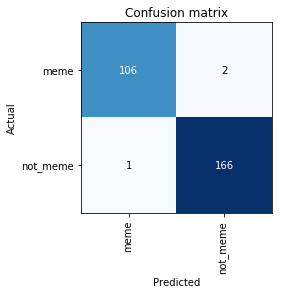

In [116]:
interp.plot_confusion_matrix()

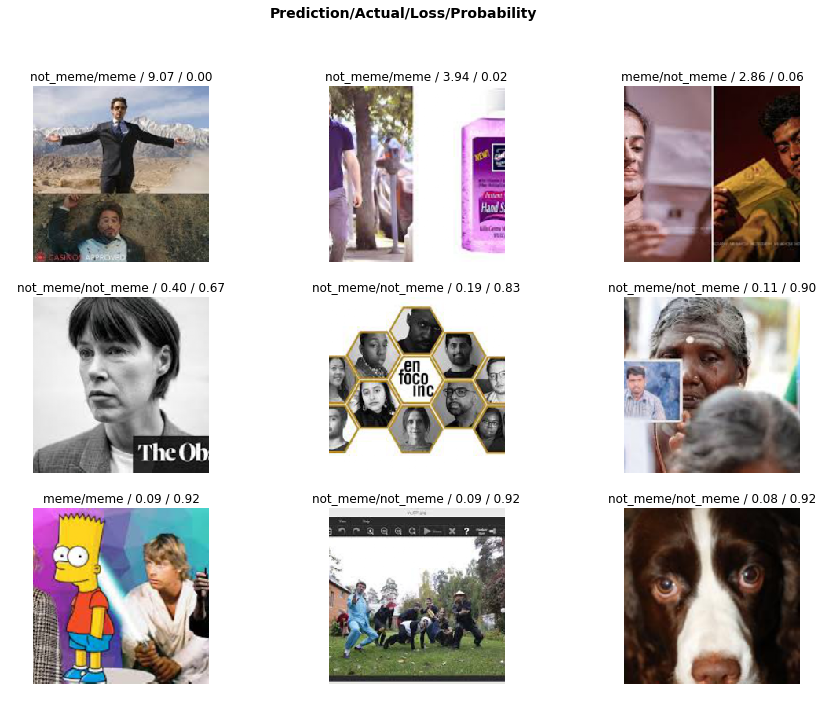

In [117]:
interp.plot_top_losses(9 ,figsize=(15,11))

## Interpret test data

In [118]:
data_test = ImageDataBunch.from_folder(path, train='train', valid='test',
                                  size=224, bs=64, ds_tfms=tfms
                                  ).normalize(imagenet_stats)

In [119]:
learn.validate(data_test.valid_dl)

[0.19599178, tensor(0.0302)]

In [121]:
learn_test = cnn_learner(data_test, models.resnet34, metrics=error_rate)

learn_test.load('stage-cleaned-resnet34');

In [123]:
interp_test = ClassificationInterpretation.from_learner(learn_test)

losses,idxs = interp_test.top_losses()

len(data_test.valid_ds)==len(losses)==len(idxs), len(data_test.valid_ds), len(idxs)

(True, 995, 995)

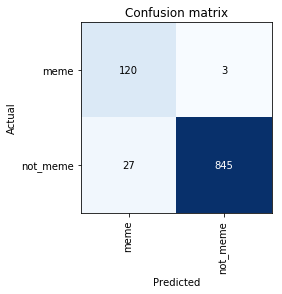

In [124]:
interp_test.plot_confusion_matrix()

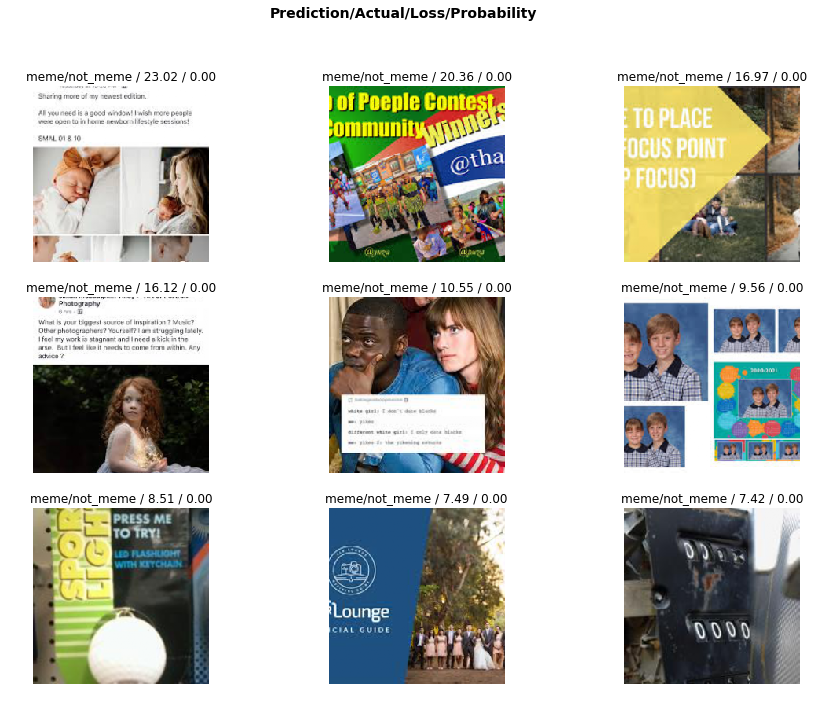

In [125]:
interp_test.plot_top_losses(9, figsize=(15,11))

## Prediction
### On Single image 

In [126]:
learn = load_learner(path)

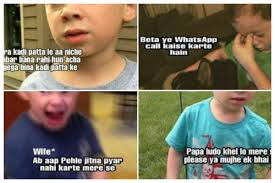

In [127]:
img = open_image(path/'test'/'meme'/'00000006.jpg'); img

In [128]:
pred_class,pred_idx,outputs = learn.predict(img); pred_class

Category meme

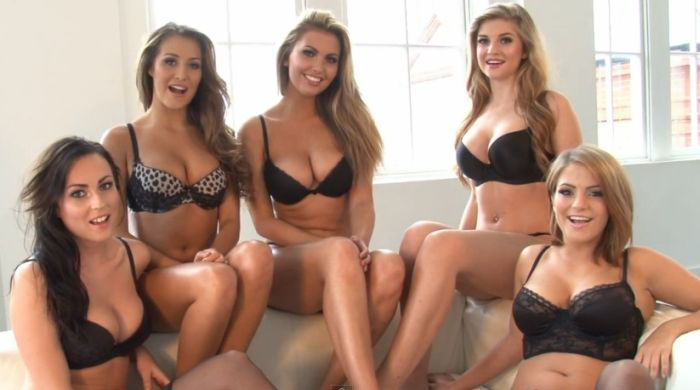

In [147]:
img = open_image(path/'test_2'/'rand_pic.jpg'); img

In [148]:
pred_class,pred_idx,outputs = learn.predict(img); pred_class

Category not_meme

### On multiple images

In [137]:
test_ds = (ImageList.from_folder(path)
                   .filter_by_folder(include='test')
                   .split_none()
                   .label_empty()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [138]:
learn.data.add_test(test_ds.train_dl.x)

In [144]:
pred, _ = learn.get_preds(ds_type=DatasetType.Test)

In [145]:
labels = pred.argmax(dim=1); labels[:5]

tensor([0, 1, 1, 1, 1])

In [146]:
classes = [learn.data.y.reconstruct(labels[i]) for i in range(len(labels))]; classes[:5]

[Category meme,
 Category not_meme,
 Category not_meme,
 Category not_meme,
 Category not_meme]